## 1. Load libraries

In [1]:
# Load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import os
#import mpld3
#mpld3.enable_notebook()

## 2. Utilitary function to plot confusion matrix

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          name=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if not os.path.exists('../plots'):
        os.mkdir('../plots')
    plt.savefig('../plots/{}.eps'.format(name))

## 3. Load datasets

In [3]:
# Load datasets
df_train = pd.read_csv('../data/Customer_train.txt')
df_new_data = pd.read_csv('../data/Customer_test.csv')

In [4]:
# Split datasets in train/test
cols = df_train.columns
X = df_train[cols[:-1]]
y = df_train['buys_computer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_dnn = X_train.copy()
X_test_dnn = X_test.copy()
X_new_data = df_new_data.iloc[:,1:5]
X_new_data_dnn = X_new_data.copy()

## 4. Data exploration

In [5]:
def build_distribution_plots(df_train):
    for var in df_train.columns.values:
        counts = df_train[var].value_counts()
        names = list()
        values = list()
        for key, value in counts.items():
            names.append(key)
            values.append(value)
        x = np.arange(len(values))
        fig, ax = plt.subplots(figsize=(6, 6))  
        for i, v in enumerate(values):
            ax.text(i - .17, v + .03 * v, str(v))
        plt.bar(x, values)
        plt.xticks(x, names)
        plt.xlabel(var)
        plt.ylabel('counts')
        plt.ylim(0, max(values) + 0.15 * max(values))
        plt.title('Distribution of {} variable'.format(var))
        if not os.path.exists('../plots'):
            os.mkdir('../plots')
        plt.savefig('../plots/{}.eps'.format(var))
        plt.show()

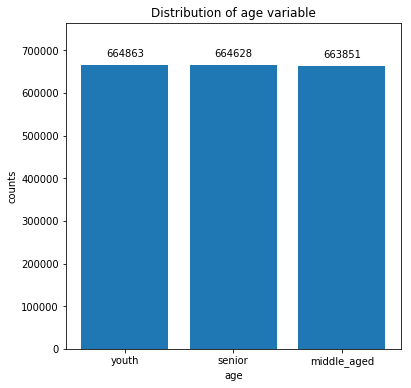

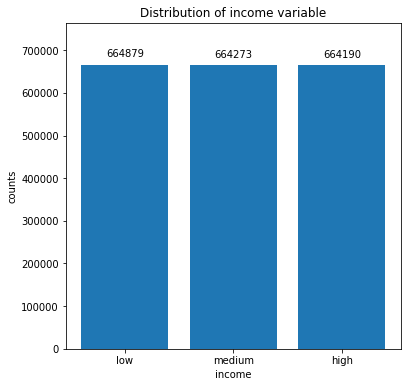

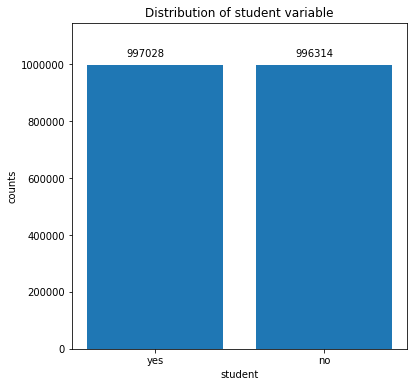

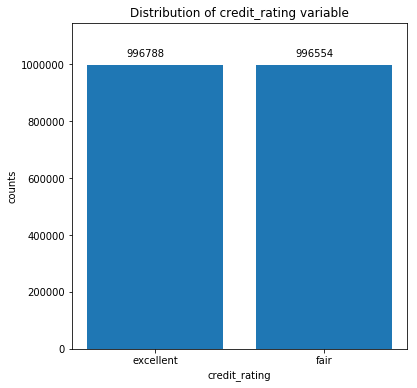

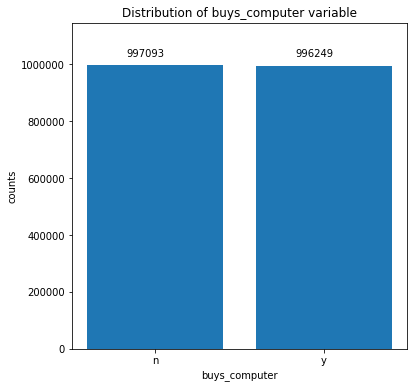

In [6]:
build_distribution_plots(df_train)

## 5. Estimation with model based in [Naive Bayes Classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

In [7]:
# Encoding columns as categorical data
for column in X_train.columns:
    X_train[column] = X_train[column].astype('category').cat.codes
    X_test[column] = X_test[column].astype('category').cat.codes
    X_new_data[column] = X_new_data[column].astype('category').cat.codes

# Set model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Obtain predictions in test dataset
y_pred_test = mnb.predict(X_test)

# Obtain predictions for new dataset
y_pred_new_data = mnb.predict(X_new_data)

/home/pacho/anaconda3/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pacho/anaconda3/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
# Append predictions column
df_new_data_pred = pd.concat([df_new_data.iloc[:,1:5], pd.Series(y_pred_new_data)], axis=1)
df_new_data_pred.columns = np.append(df_new_data_pred.columns[:-1].values, 'Prediction')
df_new_data_pred.head()

,age,income,student,credit_rating,Prediction
0,youth,high,no,fair,y
1,youth,high,no,excellent,y
2,middle_aged,high,no,fair,n
3,senior,medium,no,fair,n
4,senior,low,yes,fair,n


In [9]:
# Get accuracy in train dataset
print('Accuracy in test dataset is: {}%'.format(
    np.round((y_test == y_pred_test).sum() / len(X_test) * 100, 2)))

Accuracy in test dataset is: 50.13%


Normalized confusion matrix
[[0.55606152 0.44393848]
 [0.55360852 0.44639148]]


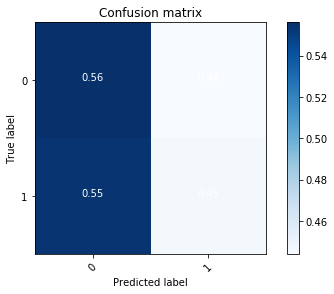

In [10]:
# Get confusion matrix
conf_nb = confusion_matrix(y_test, y_pred_test)
plt.figure()
plot_confusion_matrix(conf_nb, classes=np.array([0,1]),  
                      normalize=True,
                      name='Conf_NB_without_fix_data')

## 6. Fix paradoxical data

In [11]:
# Create copy of matrix
df_paradox = df_train[cols[:-1]].copy()

In [12]:
# Collapse predictor
def paste_line(x):
    return '_'.join(x)
collapse_predictor = df_paradox.apply(lambda x: paste_line(x), axis=1)

In [13]:
# Print Predictor, number of ocurrences and its distribution 
for i in collapse_predictor.unique():
    print('-'* 80)
    print('Predictor: {}'.format({x: y for x,y in zip(df_paradox.columns.values, i.split('_'))}))
    subdf = df_train.loc[collapse_predictor[collapse_predictor == i].index]
    print('Number of cases: {}'.format(len(subdf)))
    counts = subdf['buys_computer'].value_counts()
    print('Yes cases: {}'.format(counts['y']))
    print('No cases: {}'.format(counts['n']))

--------------------------------------------------------------------------------
Predictor: {'age': 'senior', 'income': 'high', 'student': 'no', 'credit_rating': 'fair'}
Number of cases: 55512
Yes cases: 27823
No cases: 27689
--------------------------------------------------------------------------------
Predictor: {'age': 'middle', 'income': 'aged', 'student': 'medium', 'credit_rating': 'yes'}
Number of cases: 54845
Yes cases: 27237
No cases: 27608
--------------------------------------------------------------------------------
Predictor: {'age': 'youth', 'income': 'low', 'student': 'no', 'credit_rating': 'fair'}
Number of cases: 55398
Yes cases: 27872
No cases: 27526
--------------------------------------------------------------------------------
Predictor: {'age': 'youth', 'income': 'high', 'student': 'yes', 'credit_rating': 'fair'}
Number of cases: 55277
Yes cases: 27532
No cases: 27745
--------------------------------------------------------------------------------
Predictor: {'a

In [14]:
# Fixed dataset randomly
df_fixed = df_train.copy()
np.random.seed(40)
for i in collapse_predictor.unique():
    subdf = df_fixed.loc[collapse_predictor[collapse_predictor == i].index]
    df_fixed.loc[subdf.index, 'buys_computer'] = 'y' if np.random.rand() >= .5 else 'n'

In [15]:
# Create dataset collisions y response variable (10% of dataset)
index_change = np.random.choice(np.arange(len(df_fixed)), size=int(.1 * len(df_fixed)), replace=False)
buys = df_fixed['buys_computer']
buys[index_change] = np.array(['y' if x == 'n' else 'n' for x in buys[index_change]])
df_fixed['buys_computer'] = buys

In [16]:
# Print again predictor, number of ocurrences and its distribution 
for i in collapse_predictor.unique():
    print('-'* 80)
    print('Predictor: {}'.format({x: y for x,y in zip(df_paradox.columns.values, i.split('_'))}))
    subdf = df_fixed.loc[collapse_predictor[collapse_predictor == i].index]
    print('Number of cases: {}'.format(len(subdf)))
    counts = subdf['buys_computer'].value_counts()
    print('Yes cases: {}'.format(counts['y']))
    print('No cases: {}'.format(counts['n']))

--------------------------------------------------------------------------------
Predictor: {'age': 'senior', 'income': 'high', 'student': 'no', 'credit_rating': 'fair'}
Number of cases: 55512
Yes cases: 5487
No cases: 50025
--------------------------------------------------------------------------------
Predictor: {'age': 'middle', 'income': 'aged', 'student': 'medium', 'credit_rating': 'yes'}
Number of cases: 54845
Yes cases: 5557
No cases: 49288
--------------------------------------------------------------------------------
Predictor: {'age': 'youth', 'income': 'low', 'student': 'no', 'credit_rating': 'fair'}
Number of cases: 55398
Yes cases: 49766
No cases: 5632
--------------------------------------------------------------------------------
Predictor: {'age': 'youth', 'income': 'high', 'student': 'yes', 'credit_rating': 'fair'}
Number of cases: 55277
Yes cases: 5457
No cases: 49820
--------------------------------------------------------------------------------
Predictor: {'age':

## 7. Split datasets again

In [17]:
X = df_fixed[cols[:-1]]
y = df_fixed['buys_computer']
X_train_fixed, X_test_fixed, y_train_fixed, y_test_fixed = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_fixed_dnn = X_train_fixed.copy()
X_test_fixed_dnn = X_test_fixed.copy()

## 8. Run NaiveBayes again but over fixed dataset

In [18]:
# Encoding columns as categorical data
for column in X_train.columns:
    X_train_fixed[column] = X_train_fixed[column].astype('category').cat.codes
    X_test_fixed[column] = X_test_fixed[column].astype('category').cat.codes

mnb = MultinomialNB()
mnb.fit(X_train_fixed, y_train_fixed)

# Obtain predictions in test dataset
y_pred_test_fixed = mnb.predict(X_test_fixed)

# Obtain predictions for new dataset
y_pred_new_data = mnb.predict(X_new_data)

/home/pacho/anaconda3/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/pacho/anaconda3/envs/jupyter3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
# Get accuracy in train dataset
print('Accuracy in test dataset is: {}%'.format(
    np.round((y_test_fixed == y_pred_test_fixed).sum() / len(X_test_fixed) * 100, 2)))

Accuracy in test dataset is: 63.41%


Normalized confusion matrix
[[0.34226555 0.65773445]
 [0.12192292 0.87807708]]


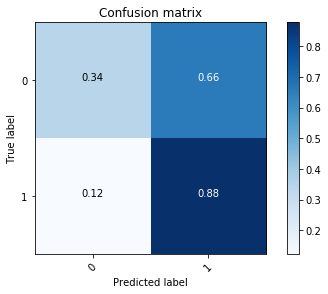

In [20]:
# Get confusion matrix
conf_nb = confusion_matrix(y_test_fixed, y_pred_test_fixed)
plt.figure()
plot_confusion_matrix(conf_nb, classes=np.array([0,1]),
                      normalize=True,
                      name='Conf_NB_with_fix_data')

## 9. Estimation with model based in [Deep Neural Network Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)

In [21]:
# Encode categorical vars for DNN
age = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("age", X_train_fixed_dnn['age'].unique().tolist()))
income = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("income", X_train_fixed_dnn['income'].unique().tolist()))
student = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("student", X_train_fixed_dnn['student'].unique().tolist()))
credit_rating = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list("credit_rating", X_train_fixed_dnn['credit_rating'].unique().tolist()))

In [22]:
# Feature columns for DNN
feat_cols = [age, income, student, credit_rating]

In [23]:
# Casting y var from string to integer
y_train_fixed_dnn = pd.Series([1 if x == 'y' else 0 for x in y_train_fixed])
y_test_fixed_dnn = pd.Series([1 if x == 'y' else 0 for x in y_test_fixed])
y_train_fixed_dnn.index = y_train_fixed.index
y_test_fixed_dnn.index = y_test_fixed.index

In [24]:
# Set function to estimate
input_func=tf.estimator.inputs.pandas_input_fn(x=X_train_fixed_dnn, y=y_train_fixed_dnn, batch_size=100,
                                               num_epochs=None,shuffle=True)

In [25]:
# Set model based in DNN
model = tf.estimator.DNNClassifier(feature_columns=feat_cols, hidden_units=[20, 10])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpw5ae2cr7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9d6d8f0f98>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [26]:
# Train model
model.train(input_fn=input_func,steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpw5ae2cr7/model.ckpt.
INFO:tensorflow:loss = 73.02305, step = 1
INFO:tensorflow:global_step/sec: 691.677
INFO:tensorflow:loss = 40.119057, step = 101 (0.147 sec)
INFO:tensorflow:global_step/sec: 787.649
INFO:tensorflow:loss = 40.084984, step = 201 (0.129 sec)
INFO:tensorflow:global_step/sec: 805.053
INFO:tensorflow:loss = 37.78852, step = 301 (0.121 sec)
INFO:tensorflow:global_step/sec: 861.735
INFO:tensorflow:loss = 29.288887, step = 401 (0.116 sec)
INFO:tensorflow:global_step/sec: 840.532
INFO:tensorflow:loss = 22.721321, step = 501 (0.119 sec)
INFO:tensorflow:global_step/sec: 799.544
INFO:tensorflow:loss = 37.297173, step = 601 (0.126 sec)
INFO:tensorflow:global_step/sec: 809.413
INFO:tensorflow:loss = 26.661957, step = 701 (0.123 sec)
INFO:tensorflow:global_step/sec: 830.58
INFO:tensorflow:loss = 34.171204, step = 801 (0.120 sec)
INFO:tensorflow:global_step/sec: 819.432
INFO:tensorflow:

In [27]:
# Get predictions for train dataset
pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test_fixed_dnn,batch_size=len(X_test_fixed_dnn),shuffle=False)

In [28]:
predictions = list(model.predict(input_fn=pred_fn))

INFO:tensorflow:Restoring parameters from /tmp/tmpw5ae2cr7/model.ckpt-2000


In [29]:
# prediction example
predictions[0]

{'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'logistic': array([0.07689608], dtype=float32),
 'logits': array([-2.485287], dtype=float32),
 'probabilities': array([0.9231039 , 0.07689608], dtype=float32)}

In [30]:
# Get all predictions
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])

In [31]:
# Get accuracy in train dataset
print('Accuracy in test dataset is: {}%'.format(
    np.round((np.array(final_preds) == y_test_fixed_dnn.values).sum() / len(y_test_fixed_dnn) * 100, 2)))

Accuracy in test dataset is: 89.96%


Normalized confusion matrix
[[0.87755957 0.12244043]
 [0.08201384 0.91798616]]


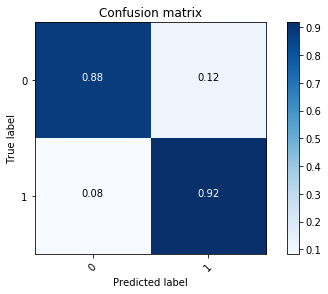

In [32]:
# Get confusion matriz
conf_dnn = confusion_matrix(y_test_fixed_dnn,final_preds)
plt.figure()
plot_confusion_matrix(conf_dnn, 
                      classes=np.array([0,1]), 
                      normalize=True,
                      name='Conf_DNN_with_fix_data')

In [33]:
pred_fn_new_data = tf.estimator.inputs.pandas_input_fn(x=X_new_data_dnn,batch_size=len(X_new_data_dnn),shuffle=False)

In [34]:
predictions_test = list(model.predict(input_fn=pred_fn_new_data))

INFO:tensorflow:Restoring parameters from /tmp/tmpw5ae2cr7/model.ckpt-2000


In [35]:
final_preds = []
for pred in predictions_test:
    final_preds.append(pred['class_ids'][0])

In [36]:
# Append predictions column
string_preds = pd.Series(['y' if x == 1 else 'n' for x in final_preds])
df_new_data_pred_dnn = pd.concat([df_new_data.iloc[:,1:5], pd.Series(string_preds)], axis=1)
df_new_data_pred_dnn.columns = np.append(df_new_data_pred_dnn.columns[:-1].values, 'Dnn')
print(df_new_data_pred_dnn)

            age  income student credit_rating Dnn
0         youth    high      no          fair   n
1         youth    high      no     excellent   y
2   middle_aged    high      no          fair   n
3        senior  medium      no          fair   n
4        senior     low     yes          fair   y
5        senior     low     yes     excellent   n
6   middle_aged     low     yes     excellent   n
7         youth  medium      no          fair   n
8         youth     low     yes          fair   y
9        senior  medium     yes          fair   n
10        youth  medium     yes     excellent   n
11  middle_aged  medium      no     excellent   y
12  middle_aged    high     yes          fair   y
13       senior  medium      no     excellent   y
